# **Notice:**
**the code in this notebook is not entirely correct. I just needed I workspace to test numba.**

# Benchmarks

In this notebook, I try different versions of the functions defined in pyFCI to optimize the usage of [numba](http://numba.pydata.org/)'s just-in-time compilation capabilities.

The main points are: 
- apparently, I cannot write efficient numpy code!
- parallelizing is not particularly efficient for the problems I face.

Legend:

| Function name | Description |
|---|---|
| "clean" | numba-compilable function |
| "np"    | numpy function, mostly not numba-compilable, as of first version of the pyFCI code|
| "jit"  | function compiled with @njit(parallel=False,fastmath=False) |
| "jit_fm"  | function compiled with @njit(parallel=False,fastmath=True) |
| "jit_p"  | function compiled with @njit(parallel=True,fastmath=False) |
| "jit_p_fm"  | function compiled with @njit(parallel=True,fastmath=True) |

In [2]:
import numpy as np
import scipy as scy
import scipy.special as scyspc
import scipy.optimize as scyopt
from numba import jit,njit,prange,vectorize,float64
from tabulate import tabulate

import pyFCI as pyfci

## Center and normalize

In [3]:
def center_and_normalize(dataset):
    """
    Center and normalize a **dataset** of N d-dimensional points so that its Euclidean barycenter is the zero vector, and each of its points has norm 1. 

    :param dataset: vector of shape (N,d)
    :returns: vector of shape (N,d)
    """
    mean = np.mean(dataset,axis=0)
    return np.array([ vec / np.linalg.norm(vec) for vec in dataset - mean ])

In [29]:
def CN_clean(a):
    (n1,n2) = np.shape(a)
    r = np.empty((n1,n2))
    mean = np.empty(n2)
    for i in range(n2):
        mean[i] = np.mean(a[:,i])
    for i in range(n1):
        v = a[i] - mean
        r[i] = v / np.linalg.norm(v)
    return r

def CN_np_old(a):
    mean = np.mean(a,axis=0)
    return np.array([ vec / np.linalg.norm(vec) for vec in a - mean ])
    
def CN_np(a):
    mean = np.mean(a,axis=0)
    std = np.std(a,axis=0)
    return (a - mean)/std

@njit(parallel=False)
def CN_jit(a):
    (n1,n2) = np.shape(a)
    r = np.empty((n1,n2))
    mean = np.empty(n2)
    for i in prange(n2):
        mean[i] = np.mean(a[:,i])
    for i in prange(n1):
        v = a[i] - mean
        r[i] = v / np.linalg.norm(v)
    return r

@njit(parallel=False,fastmath = True)
def CN_jit_fm(a):
    (n1,n2) = np.shape(a)
    r = np.empty((n1,n2))
    mean = np.empty(n2)
    for i in prange(n2):
        mean[i] = np.mean(a[:,i])
    for i in prange(n1):
        v = a[i] - mean
        r[i] = v / np.linalg.norm(v)
    return r

@njit(parallel=True)
def CN_jit_p(a):
    (n1,n2) = np.shape(a)
    r = np.empty((n1,n2))
    mean = np.empty(n2)
    for i in prange(n2):
        mean[i] = np.mean(a[:,i])
    for i in prange(n1):
        v = a[i] - mean
        r[i] = v / np.linalg.norm(v)
    return r

@njit(parallel=True,fastmath = True)
def CN_jit_p_fm(a):
    (n1,n2) = np.shape(a)
    r = np.empty((n1,n2))
    mean = np.empty(n2)
    for i in prange(n2):
        mean[i] = np.mean(a[:,i])
    for i in prange(n1):
        v = a[i] - mean
        r[i] = v / np.linalg.norm(v)
    return r

CN_funs = [CN_clean,CN_np,CN_np_old,CN_jit,CN_jit_fm,CN_jit_p,CN_jit_p_fm]

In [23]:
v = np.random.random((10,2))
o = CN_np(v)
print(o,o.mean(axis=0),o.std(axis=0))

[[-0.71675787 -0.48746453]
 [-1.61127446 -1.12431385]
 [-0.09732754 -0.91092788]
 [-1.43583931  1.31798183]
 [-0.30808587 -0.66137986]
 [ 0.25116441  1.26005597]
 [ 1.33124819 -1.1823158 ]
 [ 1.26763929  1.11180102]
 [ 0.20595043  1.06057845]
 [ 1.11328273 -0.38401534]] [-1.33226763e-16 -3.33066907e-17] [1. 1.]


In [30]:
# compile with trivial input
v = np.random.random((10,2))
output = []
for i in range(len(CN_funs)):
    CN_funs[i](v)
    output.append( [ CN_funs[i].__name__ , "Done" ])
print(tabulate(output, headers=["Function","Ready?"]))

Function        Ready?
--------------  --------
CN_clean        Done
CN_np           Done
CN_np_old       Done
CN_jit          Done
CN_jit_fm       Done
CN_jit_p        Done
CN_jit_p_fm     Done
CN_np_parallel  Done


In [19]:
# compute with easy input
print("Easy input | shape: 100,20")
v = np.random.random((100,20))
output = []
for i in range(len(CN_funs)):
    t = %timeit -q -o CN_funs[i](v)
    output.append( [ CN_funs[i].__name__ , str(t) ])
print(tabulate(output, headers=["Function","Timing"]))

Easy input | shape: 100,20
Function     Timing
-----------  -------------------------------------------------------------------------
CN_clean     549 µs ± 27.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
CN_np        49.9 µs ± 1.2 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
CN_np_old    396 µs ± 9.03 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
CN_jit       22.5 µs ± 262 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
CN_jit_fm    25.6 µs ± 216 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
CN_jit_p     23.6 µs ± 344 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
CN_jit_p_fm  26.3 µs ± 764 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [20]:
# compute with medium input
print("Medium input | shape: 5000,100")
v = np.random.random((5000,100))
output = []
for i in range(len(CN_funs)):
    t = %timeit -q -o CN_funs[i](v)
    output.append( [ CN_funs[i].__name__ , str(t) ])
print(tabulate(output, headers=["Function","Timing"]))

Medium input | shape: 5000,100
Function     Timing
-----------  -------------------------------------------------------------------------
CN_clean     25.6 ms ± 485 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
CN_np        6.02 ms ± 171 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CN_np_old    21.7 ms ± 317 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
CN_jit       2.5 ms ± 48.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CN_jit_fm    2.65 ms ± 22.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CN_jit_p     1.13 ms ± 14.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
CN_jit_p_fm  1.46 ms ± 131 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [13]:
# compute with hard input
print("Hard input | shape: 20000,1000")
v = np.random.random((20000,1000))
output = []
for i in range(len(CN_funs)):
    t = %timeit -q -o CN_funs[i](v)
    output.append( [ CN_funs[i].__name__ , str(t) ])
print(tabulate(output, headers=["Function","Timing"]))

Hard input | shape: 20000,1000
Function     Timing
-----------  ---------------------------------------------------------------------
CN_clean     237 ms ± 2.52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
CN_np        163 ms ± 1.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
CN_np_old    275 ms ± 3.39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
CN_jit       127 ms ± 700 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
CN_jit_fm    125 ms ± 1.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
CN_jit_p     130 ms ± 2.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
CN_jit_p_fm  138 ms ± 2.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## FCI

In [102]:
@njit
def FCI(dataset):
    """
    Compute the full correlation integral of a **dataset** of N d-dimensional points by exact enumeration

    :param dataset: vector of shape (N,d)
    :returns: vector of shape (N(N-1)/2,2)
    """
    rs = np.empty(0)
    n = len(dataset)
    for i in range(n):
        for j in range(i+1,n):
            r = np.linalg.norm(dataset[i]-dataset[j])
            rs = np.append(rs, r)
    return np.transpose( [ np.sort(rs) , np.linspace(0,1,num=int(n*(n-1)/2)) ] )

In [105]:
def FCI_clean(dataset):
    n = len(dataset)
    m = int(n*(n-1)/2)
    rs = np.empty(m)
    c = 0
    for i in range(n):
        for j in range(i+1,n):
            rs[c] = np.linalg.norm(dataset[i]-dataset[j])
            c += 1
    rs = np.sort(rs)
    r = np.empty((m,2))
    for i in range(m):
        r[i] = np.array([ rs[i] , i*1./m ])
    return r

def FCI_np_old(dataset):
    rs = np.empty(0)
    n = len(dataset)
    for i in range(n):
        for j in range(i+1,n):
            r = np.linalg.norm(dataset[i]-dataset[j])
            rs = np.append(rs, r)
    return np.transpose( [ np.sort(rs) , np.linspace(0,1,num=int(n*(n-1)/2)) ] )
   
def FCI_np(dataset):
    n = len(dataset)
    m = int(n*(n-1)/2)
    rs = np.empty(m)
    c = 0
    for i in range(n):
        for j in range(i+1,n):
            r = np.linalg.norm(dataset[i]-dataset[j])
            rs[c] = r
            c += 1
    return np.transpose( [ np.sort(rs) , np.linspace(0,1,num=m) ] )

def FCI_np_new(dataset):
    n = len(dataset)
    m = int(n*(n-1)/2)
    rs = np.empty(m,dtype=np.float64)
    c = 0
    for i in range(n):
        r = np.linalg.norm(dataset[i]-dataset[i+1:],axis=1)
        #c1 = len(r)
        c1 = n - i - 1
        rs[c:c+c1] = r
        c += c1
    return np.transpose( [ np.sort(rs) , np.linspace(0,1,num=m) ] )

@njit(parallel=False)
def FCI_jit(dataset):
    n = len(dataset)
    m = int(n*(n-1)/2)
    rs = np.empty(m)
    c = 0
    for i in prange(n):
        for j in prange(i+1,n):
            rs[c] = np.linalg.norm(dataset[i]-dataset[j])
            c += 1
    rs = np.sort(rs)
    r = np.empty((m,2))
    for i in prange(m):
        r[i] = np.array([ rs[i] , i*1./m ])
    return r

@njit(parallel=False,fastmath=True)
def FCI_jit_fm(dataset):
    n = len(dataset)
    m = int(n*(n-1)/2)
    rs = np.empty(m)
    c = 0
    for i in prange(n):
        for j in prange(i+1,n):
            rs[c] = np.linalg.norm(dataset[i]-dataset[j])
            c += 1
    rs = np.sort(rs)
    r = np.empty((m,2))
    for i in prange(m):
        r[i] = np.array([ rs[i] , i*1./m ])
    return r

@njit(parallel=True)
def FCI_jit_p(dataset):
    n = len(dataset)
    m = int(n*(n-1)/2)
    rs = np.empty(m)
    c = 0
    for i in prange(n):
        for j in prange(i+1,n):
            rs[c] = np.linalg.norm(dataset[i]-dataset[j])
            c += 1
    rs = np.sort(rs)
    r = np.empty((m,2))
    for i in prange(m):
        r[i] = np.array([ rs[i] , i*1./m ])
    return r

@njit(parallel=True,fastmath = True)
def FCI_jit_p_fm(dataset):
    n = len(dataset)
    m = int(n*(n-1)/2)
    rs = np.empty(m)
    c = 0
    for i in prange(n):
        for j in prange(i+1,n):
            rs[c] = np.linalg.norm(dataset[i]-dataset[j])
            c += 1
    rs = np.sort(rs)
    r = np.empty((m,2))
    for i in prange(m):
        r[i] = np.array([ rs[i] , i*1./m ])
    return r

@njit(parallel=True,fastmath = True)
# this function doesn't work
def FCI_np_parallel(dataset):
    n = len(dataset)
    m = int(n*(n-1)/2)
    rs = np.empty(m,dtype=np.float64)
    c = 0
    for i in prange(n):
        c1 = n - i - 1
        rs[c:c+c1] = np.linalg.norm(dataset[i]-dataset[i+1:],axis=1)
        #c1 = len(r)
        c += c1
    rs = np.sort(rs)
    r = np.empty((m,2))
    for i in prange(m):
        r[i] = np.array([ rs[i] , i*1./m ])
    
    return r


FCI_funs = [FCI_clean,FCI_np_old,FCI_np,FCI_np_new,FCI_jit,FCI_jit_fm,FCI_jit_p,FCI_jit_p_fm,FCI_np_parallel]

In [106]:
# compile with trivial input
v = np.random.random((10,2))
output = []
for i in range(len(FCI_funs)):
    FCI_funs[i](v)
    output.append( [ FCI_funs[i].__name__ , "Done" ])
print(tabulate(output, headers=["Function","Ready?"]))

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<function norm at 0x7f1fec2e11c0>) found for signature:
 
 >>> norm(array(float64, 2d, C), axis=Literal[int](1))
 
There are 2 candidate implementations:
      - Of which 2 did not match due to:
      Overload in function 'norm_impl': File: numba/np/linalg.py: Line 2427.
        With argument(s): '(array(float64, 2d, C), axis=int64)':
       Rejected as the implementation raised a specific error:
         TypingError: got an unexpected keyword argument 'axis'
  raised from /home/jacopo/Python_local/lib/python3.11/site-packages/numba/core/typing/templates.py:784

During: resolving callee type: Function(<function norm at 0x7f1fec2e11c0>)
During: typing of call at /tmp/ipykernel_37955/4185330645.py (122)


File "../../../../../../../../tmp/ipykernel_37955/4185330645.py", line 122:
<source missing, REPL/exec in use?>


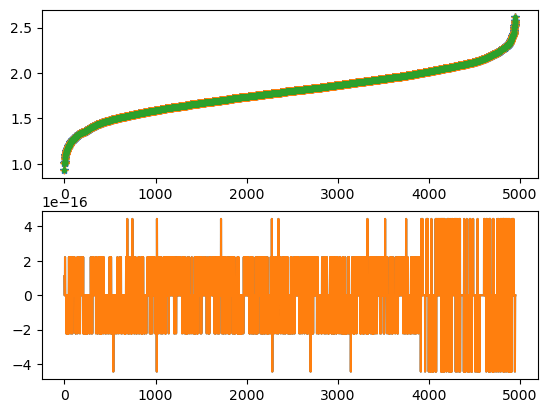

In [80]:
import matplotlib.pyplot as plt
v = np.random.random((100,20))
o_np_old = FCI_np_old(v)
o_np = FCI_np(v)
o_np_new = FCI_np_new(v)
diff = o_np - o_np_old
#print(diff, o_np_old.shape, o_np.shape, o_np_new.shape)
fig,ax = plt.subplots(2,1)
ax[0].plot(o_np[:,0],"*-")
ax[0].plot(o_np_old[:,0],"+-")
ax[0].plot(o_np_new[:,0],".-")
ax[1].plot(o_np[:,0]-o_np_new[:,0])
ax[1].plot(o_np_old[:,0]-o_np_new[:,0])
plt.show()


In [97]:
# compute with easy input
print("Easy input | shape: 100,20")
v = np.random.random((100,20))
output = []
for i in range(len(FCI_funs)):
    t = %timeit -q -o FCI_funs[i](v)
    output.append( [ FCI_funs[i].__name__ , str(t) ])
print(tabulate(output, headers=["Function","Timing"]))

Easy input | shape: 100,20


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<function norm at 0x7f1fec2e11c0>) found for signature:
 
 >>> norm(array(float64, 2d, C), axis=Literal[int](1))
 
There are 2 candidate implementations:
      - Of which 2 did not match due to:
      Overload in function 'norm_impl': File: numba/np/linalg.py: Line 2427.
        With argument(s): '(array(float64, 2d, C), axis=int64)':
       Rejected as the implementation raised a specific error:
         TypingError: got an unexpected keyword argument 'axis'
  raised from /home/jacopo/Python_local/lib/python3.11/site-packages/numba/core/typing/templates.py:784

During: resolving callee type: Function(<function norm at 0x7f1fec2e11c0>)
During: typing of call at /tmp/ipykernel_37955/1230168567.py (121)


File "../../../../../../../../tmp/ipykernel_37955/1230168567.py", line 121:
<source missing, REPL/exec in use?>


In [82]:
# compute with medium input
print("Medium input | shape: 1000,100")
v = np.random.random((1000,100))
output = []
for i in range(len(FCI_funs)):
    t = %timeit -q -o FCI_funs[i](v)
    output.append( [ FCI_funs[i].__name__ , str(t) ])
print(tabulate(output, headers=["Function","Timing"]))

Medium input | shape: 1000,100
Function      Timing
------------  ----------------------------------------------------------------------
FCI_clean     2.24 s ± 56.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
FCI_np        1.85 s ± 25.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
FCI_np_old    1min 30s ± 3.32 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
FCI_np_new    128 ms ± 891 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
FCI_jit       173 ms ± 2.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
FCI_jit_fm    174 ms ± 1.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
FCI_jit_p     75.1 ms ± 1.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
FCI_jit_p_fm  87.7 ms ± 3.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [94]:
FCI_funs = [FCI_np_new,FCI_jit,FCI_jit_fm,FCI_jit_p,FCI_jit_p_fm,FCI_np_parallel]

In [93]:
# Compute with hard input
# AVOID FCI_np
print("Hard input | shape: 5000,500")
v = np.random.random((5000,500))
output = []
for i in range(len(FCI_funs)):
    t = %timeit -q -o FCI_funs[i](v)
    output.append( [ FCI_funs[i].__name__ , str(t) ])
print(tabulate(output, headers=["Function","Timing"]))

Hard input | shape: 5000,500


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<function norm at 0x7f1fec2e11c0>) found for signature:
 
 >>> norm(array(float64, 2d, C), axis=Literal[int](1))
 
There are 2 candidate implementations:
      - Of which 2 did not match due to:
      Overload in function 'norm_impl': File: numba/np/linalg.py: Line 2427.
        With argument(s): '(array(float64, 2d, C), axis=int64)':
       Rejected as the implementation raised a specific error:
         TypingError: got an unexpected keyword argument 'axis'
  raised from /home/jacopo/Python_local/lib/python3.11/site-packages/numba/core/typing/templates.py:784

During: resolving callee type: Function(<function norm at 0x7f1fec2e11c0>)
During: typing of call at /tmp/ipykernel_37955/3691014624.py (121)


File "../../../../../../../../tmp/ipykernel_37955/3691014624.py", line 121:
<source missing, REPL/exec in use?>


## FCI_MC

In [218]:
def FCI_MC(dataset,samples=500):
    """
    Compute the full correlation integral of a **dataset** of N d-dimensional points by random sampling of **samples** pair of points

    :param dataset: vector of shape (N,d)
    :param samples: positive integer
    :returns: vector of shape (N(N-1)/2,2)
    """
    samples = int(min( len(dataset)*( len(dataset)-1 )/2, samples ))
    rs = np.empty(0)
    n = len(dataset)
    for k in range(samples):
        i = np.random.randint(0,n)
        j = np.random.randint(0,n)
        r = np.linalg.norm(dataset[i]-dataset[j])
        rs = np.append(rs, r)

    return np.transpose( [ np.sort(rs) , np.linspace(0,1,num=int(samples)) ] )

In [219]:
def FCI_MC_clean(dataset,samples=500):
    n = len(dataset)
    m = int(n*(n-1)/2)
    samples = min( m, samples )
    rs = np.empty(samples)
    
    for k in range(samples):
        i = np.random.randint(0,n)
        j = np.random.randint(0,n)
        rs[k] = np.linalg.norm(dataset[i]-dataset[j])
    rs = np.sort(rs)
    
    r = np.empty((samples,2))
    for i in range(samples):
        r[i] = np.array([ rs[i] , i*1./m ])
    return r

def FCI_MC_np(dataset,samples=500):
    samples = int(min( len(dataset)*( len(dataset)-1 )/2, samples ))
    rs = np.empty(0)
    n = len(dataset)
    for k in range(samples):
        i = np.random.randint(0,n)
        j = np.random.randint(0,n)
        r = np.linalg.norm(dataset[i]-dataset[j])
        rs = np.append(rs, r)

    return np.transpose( [ np.sort(rs) , np.linspace(0,1,num=int(samples)) ] )

@njit(parallel=False)
def FCI_MC_jit(dataset,samples=500):
    n = len(dataset)
    m = int(n*(n-1)/2)
    samples = min( m, samples )
    rs = np.empty(samples)
    
    for k in prange(samples):
        i = np.random.randint(0,n)
        j = np.random.randint(0,n)
        rs[k] = np.linalg.norm(dataset[i]-dataset[j])
    rs = np.sort(rs)
    
    r = np.empty((samples,2))
    for i in prange(samples):
        r[i] = np.array([ rs[i] , i*1./m ])
    return r
    
@njit(parallel=False,fastmath=True)
def FCI_MC_jit_fm(dataset,samples=500):
    n = len(dataset)
    m = int(n*(n-1)/2)
    samples = min( m, samples )
    rs = np.empty(samples)
    
    for k in prange(samples):
        i = np.random.randint(0,n)
        j = np.random.randint(0,n)
        rs[k] = np.linalg.norm(dataset[i]-dataset[j])
    rs = np.sort(rs)
    
    r = np.empty((samples,2))
    for i in prange(samples):
        r[i] = np.array([ rs[i] , i*1./m ])
    return r

@njit(parallel=True)
def FCI_MC_jit_p(dataset,samples=500):
    n = len(dataset)
    m = int(n*(n-1)/2)
    samples = min( m, samples )
    rs = np.empty(samples)
    
    for k in prange(samples):
        i = np.random.randint(0,n)
        j = np.random.randint(0,n)
        rs[k] = np.linalg.norm(dataset[i]-dataset[j])
    rs = np.sort(rs)
    
    r = np.empty((samples,2))
    for i in prange(samples):
        r[i] = np.array([ rs[i] , i*1./m ])
    return r

@njit(parallel=True,fastmath = True)
def FCI_MC_jit_p_fm(dataset,samples=500):
    n = len(dataset)
    m = int(n*(n-1)/2)
    samples = min( m, samples )
    rs = np.empty(samples)
    
    for k in prange(samples):
        i = np.random.randint(0,n)
        j = np.random.randint(0,n)
        rs[k] = np.linalg.norm(dataset[i]-dataset[j])
    rs = np.sort(rs)
    
    r = np.empty((samples,2))
    for i in prange(samples):
        r[i] = np.array([ rs[i] , i*1./m ])
    return r

FCI_MC_funs = [FCI_MC_clean,FCI_MC_np,FCI_MC_jit,FCI_MC_jit_fm,FCI_MC_jit_p,FCI_MC_jit_p_fm]

In [220]:
# compile with trivial input
v = np.random.random((10,2))
output = []
for i in range(len(FCI_MC_funs)):
    FCI_MC_funs[i](v)
    output.append( [ FCI_MC_funs[i].__name__ , "Done" ])
print(tabulate(output, headers=["Function","Ready?"]))

Function         Ready?
---------------  --------
FCI_MC_clean     Done
FCI_MC_np        Done
FCI_MC_jit       Done
FCI_MC_jit_fm    Done
FCI_MC_jit_p     Done
FCI_MC_jit_p_fm  Done


In [223]:
# compute with easy input
print("Easy input | shape: 10000,500 | samples: 500")
v = np.random.random((10000,500))
output = []
for i in range(len(FCI_MC_funs)):
    t = %timeit -q -o FCI_MC_funs[i](v,500)
    output.append( [ FCI_MC_funs[i].__name__ , str(t) ])
print(tabulate(output, headers=["Function","Timing"]))

Easy input | shape: 10000,500 | samples: 500
Function         Timing
---------------  ----------------------------------------------------------------------
FCI_MC_clean     11.2 ms ± 633 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
FCI_MC_np        14 ms ± 530 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
FCI_MC_jit       611 µs ± 26.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
FCI_MC_jit_fm    619 µs ± 31.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
FCI_MC_jit_p     440 µs ± 30.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
FCI_MC_jit_p_fm  524 µs ± 36.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [224]:
# compute with medium input
print("Medium input | shape: 10000,500 | samples: 5000")
v = np.random.random((10000,500))
output = []
for i in range(len(FCI_MC_funs)):
    t = %timeit -q -o FCI_MC_funs[i](v,5000)
    output.append( [ FCI_MC_funs[i].__name__ , str(t) ])
print(tabulate(output, headers=["Function","Timing"]))

Medium input | shape: 10000,500 | samples: 5000
Function         Timing
---------------  -----------------------------------------------------------------------
FCI_MC_clean     109 ms ± 4.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
FCI_MC_np        143 ms ± 3.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
FCI_MC_jit       6.68 ms ± 190 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
FCI_MC_jit_fm    7.13 ms ± 168 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
FCI_MC_jit_p     4.21 ms ± 34.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
FCI_MC_jit_p_fm  4.2 ms ± 42 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [226]:
# compute with hard input
print("Hard input | shape: 10000,500 | samples: 50000")
v = np.random.random((10000,500))
output = []
for i in range(len(FCI_MC_funs)):
        t = %timeit -q -o FCI_MC_funs[i](v,50000)
        output.append( [ FCI_MC_funs[i].__name__ , str(t) ])
print(tabulate(output, headers=["Function","Timing"]))

Hard input | shape: 10000,500 | samples: 50000
Function         Timing
---------------  ----------------------------------------------------------------------
FCI_MC_clean     1.16 s ± 87.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
FCI_MC_np        1.78 s ± 79.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
FCI_MC_jit       68.3 ms ± 2.78 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
FCI_MC_jit_fm    69.5 ms ± 2.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
FCI_MC_jit_p     42.1 ms ± 669 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
FCI_MC_jit_p_fm  41.5 ms ± 460 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Analytical FCI

Seems fine as it is.

In [46]:
def anFCI_np(x,d,x0=1):
    return  0.5 * ( 1 + (scyspc.gamma((1+d)/2)) / (np.sqrt(np.pi) * scyspc.gamma(d/2) ) * (-2+(x/x0)**2) * scyspc.hyp2f1( 0.5, 1-d/2, 3/2, 1/4 * (-2+(x/x0)**2)**2 ) )

@jit(forceobj=True)
def anFCI_jit(x,d,x0=1):
    return  0.5 * ( 1 + (scyspc.gamma((1+d)/2)) / (np.sqrt(np.pi) * scyspc.gamma(d/2) ) * (-2+(x/x0)**2) * scyspc.hyp2f1( 0.5, 1-d/2, 3/2, 1/4 * (-2+(x/x0)**2)**2 ) )

@jit(forceobj=True,fastmath=True)
def anFCI_jit_fm(x,d,x0=1):
    return  0.5 * ( 1 + (scyspc.gamma((1+d)/2)) / (np.sqrt(np.pi) * scyspc.gamma(d/2) ) * (-2+(x/x0)**2) * scyspc.hyp2f1( 0.5, 1-d/2, 3/2, 1/4 * (-2+(x/x0)**2)**2 ) )


anFCI_funs = [anFCI_np,anFCI_jit,anFCI_jit_fm]

In [47]:
# compute with hard input
print("Hard input | shape: 100000 | d: 5")
v = np.random.random((100000))
output = []
for i in range(len(anFCI_funs)):
    t = %timeit -q -o anFCI_funs[i](v,5)
    output.append( [ anFCI_funs[i].__name__ , str(t) ])
print(tabulate(output, headers=["Function","Timing"]))

Hard input | shape: 100000 | d: 5
Function      Timing
------------  -------------------------------------------------------------------
anFCI_np      279 ms ± 2.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
anFCI_jit     286 ms ± 3.76 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
anFCI_jit_fm  302 ms ± 16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [48]:
# compute with hard input
print("Hard input | shape: 100000 | d: 50")
v = np.random.random((100000))
output = []
for i in range(len(anFCI_funs)):
    t = %timeit -q -o anFCI_funs[i](v,50)
    output.append( [ anFCI_funs[i].__name__ , str(t) ])
print(tabulate(output, headers=["Function","Timing"]))

Hard input | shape: 100000 | d: 50
Function      Timing
------------  ---------------------------------------------------------------------
anFCI_np      23.2 ms ± 138 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
anFCI_jit     24.8 ms ± 1.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
anFCI_jit_fm  23.6 ms ± 670 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


I'm jitting this because I think that it may compromise the parallelization of local functions later!

## fit_FCI

I think it's pointless to try jitting this one, as it calls scipy.optimize.curve_fit and then it just performs a mean square error computation.

In [16]:
def fit_FCI(rho, samples=500, threshold=0.1):
    samples = min( len(rho),samples )
    data = rho[np.random.choice(len(rho),samples)]

    fit = scyopt.curve_fit( pyfci.analytical_FCI, data[:,0], data[:,1] )
    if abs(fit[0][1] - 1)>threshold:
        return [0,0,0]
    else:
        mse = np.sqrt(np.mean([ (pt[1] - pyfci.analytical_FCI(pt[0],fit[0][0],fit[0][1]))**2 for pt in data ]))
        return [fit[0][0]+1,fit[0][1],mse]

@jit(forceobj=True,fastmath=False)
def fit_FCI_jit(rho, samples=500, threshold=0.1):
    samples = min( len(rho),samples )
    data = rho[np.random.choice(len(rho),samples)]

    fit = scyopt.curve_fit( pyfci.analytical_FCI, data[:,0], data[:,1] )
    if abs(fit[0][1] - 1)>threshold:
        return [0,0,0]
    else:
        mse = np.sqrt(np.mean([ (pt[1] - pyfci.analytical_FCI(pt[0],fit[0][0],fit[0][1]))**2 for pt in data ]))
        return [fit[0][0]+1,fit[0][1],mse]
    
@jit(forceobj=True,fastmath=True)
def fit_FCI_jit_fm(rho, samples=500, threshold=0.1):
    samples = min( len(rho),samples )
    data = rho[np.random.choice(len(rho),samples)]

    fit = scyopt.curve_fit( pyfci.analytical_FCI, data[:,0], data[:,1] )
    if abs(fit[0][1] - 1)>threshold:
        return [0,0,0]
    else:
        mse = np.sqrt(np.mean([ (pt[1] - pyfci.analytical_FCI(pt[0],fit[0][0],fit[0][1]))**2 for pt in data ]))
        return [fit[0][0]+1,fit[0][1],mse]

fit_FCI_funs = [fit_FCI,fit_FCI_jit,fit_FCI_jit_fm]

In [3]:
# compile with trivial input
v = pyfci.FCI_MC(pyfci.center_and_normalize(np.random.random((10,2))))
output = []
for i in range(len(fit_FCI_funs)):
    fit_FCI_funs[i](v)
    output.append( [ fit_FCI_funs[i].__name__ , "Done" ])
print(tabulate(output, headers=["Function","Ready?"]))

Function        Ready?
--------------  --------
fit_FCI         Done
fit_FCI_jit     Done
fit_FCI_jit_fm  Done


In [43]:
# compute with easy input
print("Easy input | shape: 100,5 | samples: 500")
v = pyfci.FCI_MC(pyfci.center_and_normalize(np.random.random((100,5))))
output = []
for i in range(len(fit_FCI_funs)):
    t = %timeit -q -o fit_FCI_funs[i](v,500)
    output.append( [ fit_FCI_funs[i].__name__ , str(t) ])
print(tabulate(output, headers=["Function","Timing"]))

Easy input | shape: 100,5 | samples: 500
Function        Timing
--------------  ----------------------------------------------------------------------
fit_FCI         16.8 ms ± 564 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
fit_FCI_jit     17.1 ms ± 535 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
fit_FCI_jit_fm  16.2 ms ± 430 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
# compute with hard input
print("Hard input | shape: 1000,50 | samples: 5000")
v = pyfci.FCI_MC(pyfci.center_and_normalize(np.random.random((1000,50))))
output = []
for i in range(len(fit_FCI_funs)):
    t = %timeit -q -o fit_FCI_funs[i](v,500)
    output.append( [ fit_FCI_funs[i].__name__ , str(t) ])
print(tabulate(output, headers=["Function","Timing"]))

Hard input | shape: 1000,50 | samples: 5000
Function        Timing
--------------  ----------------------------------------------------------------------
fit_FCI         19.4 ms ± 828 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
fit_FCI_jit     19.9 ms ± 968 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
fit_FCI_jit_fm  20.1 ms ± 482 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


I'm jitting this because I think that it may compromise the parallelization of local functions later!

## local_FCI

May benefit from jitting, if the call to an external function does not ruin everything.

In [52]:
def local_FCI_np(dataset, center, ks):
    neighbours = dataset[np.argsort(np.linalg.norm( dataset - dataset[center], axis=1))[0:ks[-1]]]    
  
    local = np.empty(shape=(0,5))
    for k in ks:
        fit = fit_FCI_jit_fm(pyfci.FCI_MC(pyfci.center_and_normalize( neighbours[0:k] ) ))
        local = np.append(local, [[ k, np.linalg.norm( neighbours[k-1] - neighbours[0] ), fit[0], fit[1], fit[2] ]], axis=0 )

    return local

def local_FCI_cl(dataset, center, ks):
    
    n = len(dataset)
    dists = np.empty(n) 
    for i in range(n):
        dists[i] = np.linalg.norm( dataset[i] - dataset[center])
    neighbours = dataset[np.argsort(dists)[0:ks[-1]]]    
  
    local = np.empty(shape=(len(ks),5))
    for i in range(len(ks)):
        k = ks[i]
        fit = fit_FCI_jit_fm( pyfci.FCI_MC( pyfci.center_and_normalize( neighbours[0:k] ) ) )
        local[i] = [ k, np.linalg.norm( neighbours[k-1] - neighbours[0] ), fit[0], fit[1], fit[2] ]

    return local

@jit(forceobj=True)
def local_FCI_jit(dataset, center, ks):
    
    n = len(dataset)
    dists = np.empty(n) 
    for i in range(n):
        dists[i] = np.linalg.norm( dataset[i] - dataset[center])
    neighbours = dataset[np.argsort(dists)[0:ks[-1]]]    
  
    local = np.empty(shape=(len(ks),5))
    for i in prange(len(ks)):
        k = ks[i]
        fit = fit_FCI_jit_fm( pyfci.FCI_MC( pyfci.center_and_normalize( neighbours[0:k] ) ) )
        local[i] = [ k, np.linalg.norm( neighbours[k-1] - neighbours[0] ), fit[0], fit[1], fit[2] ]

    return local

@jit(forceobj=True,fastmath=True)
def local_FCI_jit_fm(dataset, center, ks):
    
    n = len(dataset)
    dists = np.empty(n) 
    for i in range(n):
        dists[i] = np.linalg.norm( dataset[i] - dataset[center])
    neighbours = dataset[np.argsort(dists)[0:ks[-1]]]    
  
    local = np.empty(shape=(len(ks),5))
    for i in prange(len(ks)):
        k = ks[i]
        fit = fit_FCI_jit_fm( pyfci.FCI_MC( pyfci.center_and_normalize( neighbours[0:k] ) ) )
        local[i] = [ k, np.linalg.norm( neighbours[k-1] - neighbours[0] ), fit[0], fit[1], fit[2] ]

    return local

@jit(forceobj=True,parallel=True,fastmath=False)
def local_FCI_jit_p(dataset, center, ks):
    
    n = len(dataset)
    dists = np.empty(n) 
    for i in range(n):
        dists[i] = np.linalg.norm( dataset[i] - dataset[center])
    neighbours = dataset[np.argsort(dists)[0:ks[-1]]]    
  
    local = np.empty(shape=(len(ks),5))
    for i in prange(len(ks)):
        k = ks[i]
        fit = fit_FCI_jit_fm( pyfci.FCI_MC( pyfci.center_and_normalize( neighbours[0:k] ) ) )
        local[i] = [ k, np.linalg.norm( neighbours[k-1] - neighbours[0] ), fit[0], fit[1], fit[2] ]

    return local

@jit(forceobj=True,parallel=True,fastmath=True)
def local_FCI_jit_p_fm(dataset, center, ks):
    
    n = len(dataset)
    dists = np.empty(n) 
    for i in range(n):
        dists[i] = np.linalg.norm( dataset[i] - dataset[center])
    neighbours = dataset[np.argsort(dists)[0:ks[-1]]]    
  
    local = np.empty(shape=(len(ks),5))
    for i in prange(len(ks)):
        k = ks[i]
        fit = fit_FCI_jit_fm( pyfci.FCI_MC( pyfci.center_and_normalize( neighbours[0:k] ) ) )
        local[i] = [ k, np.linalg.norm( neighbours[k-1] - neighbours[0] ), fit[0], fit[1], fit[2] ]

    return local


@njit(parallel=True,fastmath=True)
def ordmy(dataset,center):
    n = len(dataset)
    dists = np.empty(n) 
    for i in prange(n):
        dists[i] = np.linalg.norm( dataset[i] - dataset[center])
    return dataset[np.argsort(dists)]   

def local_FCI_jit2(dataset, center, ks):
    
    neighbours = ordmy(dataset,center)[0:ks[-1]]
  
    local = np.empty(shape=(len(ks),5))
    for i in prange(len(ks)):
        k = ks[i]
        fit = fit_FCI_jit_fm( pyfci.FCI_MC( pyfci.center_and_normalize( neighbours[0:k] ) ) )
        local[i] = [ k, np.linalg.norm( neighbours[k-1] - neighbours[0] ), fit[0], fit[1], fit[2] ]

    return local

local_FCI_funs = [local_FCI_cl,local_FCI_np,local_FCI_jit,local_FCI_jit2]

In [53]:
# compile with trivial input
v = np.random.random((50,2))
ks= [4,6]
output = []
for i in range(len(local_FCI_funs)):
    local_FCI_funs[i](v,0,ks)
    output.append( [ local_FCI_funs[i].__name__ , "Done" ])
print(tabulate(output, headers=["Function","Ready?"]))

Function        Ready?
--------------  --------
local_FCI_cl    Done
local_FCI_np    Done
local_FCI_jit   Done
local_FCI_jit2  Done


In [55]:
# compute with easy input
print("Easy input | shape: 1000,10 | ks: 20,30,40,50")
v = np.random.random((1000,10))
ks= [20,30,40,50]
output = []
for i in range(len(local_FCI_funs)):
    t = %timeit -q -o local_FCI_funs[i](v,0,ks)
    output.append( [ local_FCI_funs[i].__name__ , str(t) ])
print(tabulate(output, headers=["Function","Timing"]))

Easy input | shape: 1000,10 | ks: 20,30,40,50
Function        Timing
--------------  ---------------------------------------------------------------------
local_FCI_cl    81.9 ms ± 7.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
local_FCI_np    79.2 ms ± 269 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
local_FCI_jit   78.6 ms ± 283 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
local_FCI_jit2  78.6 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
